## Anomaly Detection

In [1]:
# Import Libraries
import re
import scipy as sp
import scipy.io
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
# Load Data
data = scipy.io.loadmat('/Users/wiseer85/Documents/Data Science/ML Exercises/data/ex8data1.mat')

In [3]:
# Training Set
X = data['X']
X_val = data['Xval']
y_val = data['yval'].T[0]

M = len(X)
M_val = len(X_val)

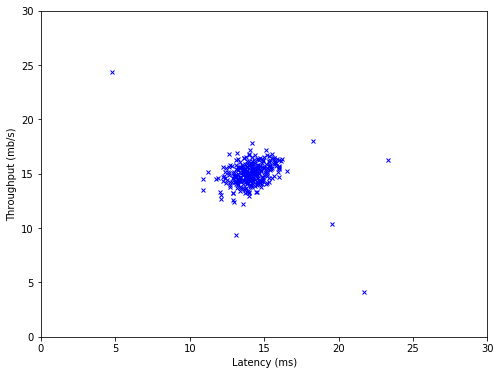

In [5]:
# Visualize the data
plt.figure(figsize=(8, 6))
plt.plot(X.T[0], X.T[1], 'bx', ms=4)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.show()

In [11]:
# Estimate parameters for Gaussian distribution
def estimate_gaussian(X):
    mu = sp.mean(X, axis=0)
    var = sp.var(X, axis=0, ddof=1)
    return mu, var

mu, var = estimate_gaussian(X)
rv = multivariate_normal(mu, sp.diag(var))

xs, ys = sp.mgrid[0:30:0.1, 0:30:0.1]
pos = sp.empty(xs.shape + (2,))
pos[:, :, 0] = xs
pos[:, :, 1] = ys

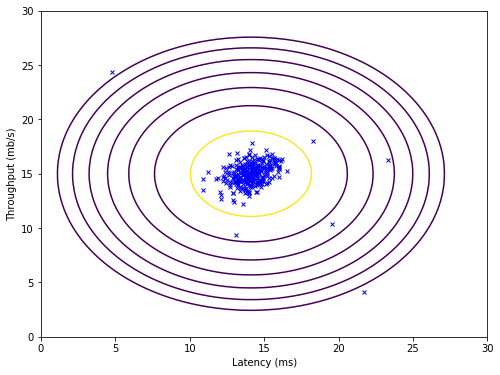

In [13]:
# Visualize the Gaussian contours
plt.figure(figsize=(8, 6))
plt.plot(X.T[0], X.T[1], 'bx', ms=4)
plt.contour(xs, ys, rv.pdf(pos), 10.**sp.arange(-21, -2, 3))
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.show()

In [14]:
# Select the threshold
p_val = rv.pdf(X_val)

In [15]:
def select_threshold(y_val, p_val):
    best_epsilon, best_F1 = 0, 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    for epsilon in sp.arange(min(p_val), max(p_val), step_size)[1:]:
        cv_predictions = p_val < epsilon
        
        tp = sp.sum((cv_predictions == 1) & (y_val == 1))
        fp = sp.sum((cv_predictions == 1) & (y_val == 0))
        fn = sp.sum((cv_predictions == 0) & (y_val == 1))
        tn = sp.sum((cv_predictions == 0) & (y_val == 0))
                
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        
        F1 = 2 * prec * rec / (prec + rec)
           
        if F1 > best_F1:
            best_epsilon = epsilon
            best_F1 = F1            
        
    return best_epsilon, best_F1

In [16]:
# Calculate F1 and epsilon scores
best_epsilon, best_F1 = select_threshold(y_val, p_val)
print("best epsilon =", best_epsilon)

best epsilon = 8.961567687193517e-05


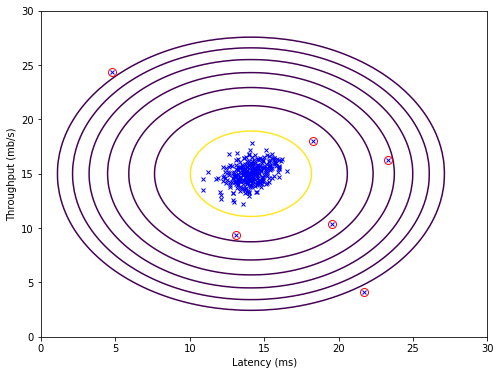

In [18]:
# Visualize anomalies
outliers = X[rv.pdf(X) < best_epsilon]

plt.figure(figsize=(8, 6))
plt.plot(X.T[0], X.T[1], 'bx', ms=4)
plt.plot(outliers.T[0], outliers.T[1], 'ro', ms=8, mfc='none', mec='r')
plt.contour(xs, ys, rv.pdf(pos), 10.**sp.arange(-21, -2, 3))
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.show()